In [59]:
%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('pgf')

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

%matplotlib inline


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

markerlist = ['o', 4, 5, 6, 7, 'p', 'd', 'P']


text_width = 5.60107  # in  --> Confirmed with template explanation
text_height = 9.0

fs_m1 = 7  # for figure ticks 
fs = 9  # for regular figure text
fs_p1 = 10  # figure titles

axes_lw = 0.7

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('axes', linewidth=axes_lw)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

matplotlib.rc('text', usetex=True)

plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})


def errorfill(ax, x, y, yerr, color=None, alpha_fill=0.3, alpha_line=1, lw=1, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label=None):
    ax.fill_between(x, y - yerr, y + yerr, color=color, alpha=alpha_fill, linewidths=fill_linewidths)
    ax.plot(x, y, color=color, lw=lw, linestyle=linestyle, alpha=alpha_line, label=label, marker=marker, markersize=markersize)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
from scalable_gps.wandb_utils import load_runs_from_sweep
import numpy as np
import os

sweep_id_dict = {
    'random-search': "gb96yqve", # done
    'cg-small': "io536maa", # done --> 10000 = 2.77 h
    'cg-large': "mbgc9ig1", # done --> 46500 = 12.9 h
    'vi-small': "v3qvdy0q", # done --> 6000 = 1.66 h
    'vi-large': "2qm8u10q", # done --> 28500 = 7.9 h
    'sgd-small': "qzytlc9l", # done, 15k iters, 0.3 train lr, 3e-4 sample lr
    'sgd-large': "aon2wq51" # done, 75k iters, 0.3 train lr, 3e-4 sample lr
}

length_scale_idx_dict = {
    0.1: 0,
    0.2: 1,
    0.3: 2,
    0.4: 3,
    0.5: 4
}

sweeps = ['random-search', 'cg-small', 'cg-large', 'vi-small', 'vi-large', 'sgd-small', 'sgd-large']

config_keys = ['thompson.seed', 'thompson.length_scale']
metric_keys = ['thompson_step', 'thompson_time', 'max_fn_value']

n_seeds = 10
n_length_scales = 5
n_thompson_steps = 30

results_path = "./thompson_results.npy"

if os.path.isfile(results_path):
    results = np.load(results_path, allow_pickle=True).item()
else:
    results = dict()
    
for sweep in sweeps:
    if sweep in results.keys():
        print(f"Results for '{sweep}' already exist.")
        continue
    results[sweep] = dict()
    results[sweep]['thompson_time'] = np.zeros((n_seeds, n_length_scales, n_thompson_steps + 1))
    results[sweep]['max_fn_value'] = np.zeros((n_seeds, n_length_scales, n_thompson_steps + 1))

    print(f"Downloading results for {sweep}")
    configs_and_metrics = load_runs_from_sweep(sweep_id_dict[sweep], config_keys, metric_keys)

    for (configs, metrics) in configs_and_metrics:
        seed = configs['thompson.seed']
        length_scale = configs['thompson.length_scale']
        length_scale_idx = length_scale_idx_dict[length_scale]
        # if np.max(metrics['thompson_step']) != 30:
        #     print(seed, length_scale, np.max(metrics['thompson_step']))

        results[sweep]['thompson_time'][seed, length_scale_idx] = metrics['thompson_time']
        results[sweep]['max_fn_value'][seed, length_scale_idx] = metrics['max_fn_value']
    np.save(results_path, results)


Results for 'random-search' already exist.
Results for 'cg-small' already exist.
Results for 'cg-large' already exist.
Results for 'vi-small' already exist.
Results for 'vi-large' already exist.
Results for 'sgd-small' already exist.
Results for 'sgd-large' already exist.


In [61]:
def get_color(id):
    if id == 'random-search':
        return 'k'
    elif 'cg' in id:
        return 'tab:orange'
    elif 'vi' in id:
        return 'tab:red'
    elif 'sgd' in id:
        return 'tab:green'
    else:
        return 'magenta'

def get_label(id):
    if id == 'random-search':
        return 'Random Search'
    elif 'cg' in id:
        return 'CG'
    elif 'vi' in id:
        return 'SVGP'
    elif 'sgd' in id:
        return 'SGD'
    else:
        return 'null'

def get_linestyle(id):
    if 'small' in id:
        return '-'
    else:
        return '-'

def remove_xticks(ax):
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    ax.set_xticklabels([])
        
def remove_yticks(ax):
    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    ax.set_yticklabels([])

axv_linestyle = '--'
axv_linewidth = 0.5

markersize = 20
def get_marker(id):
    if id == 'random-search':
        return 'd'
    elif 'cg' in id:
        return 's'
    elif 'vi' in id:
        return '^'
    elif 'sgd' in id:
        return 'o'
    else:
        return 'x'

alpha_line = 0.9
alpha_marker = 1.0
alpha_fill = 0.3

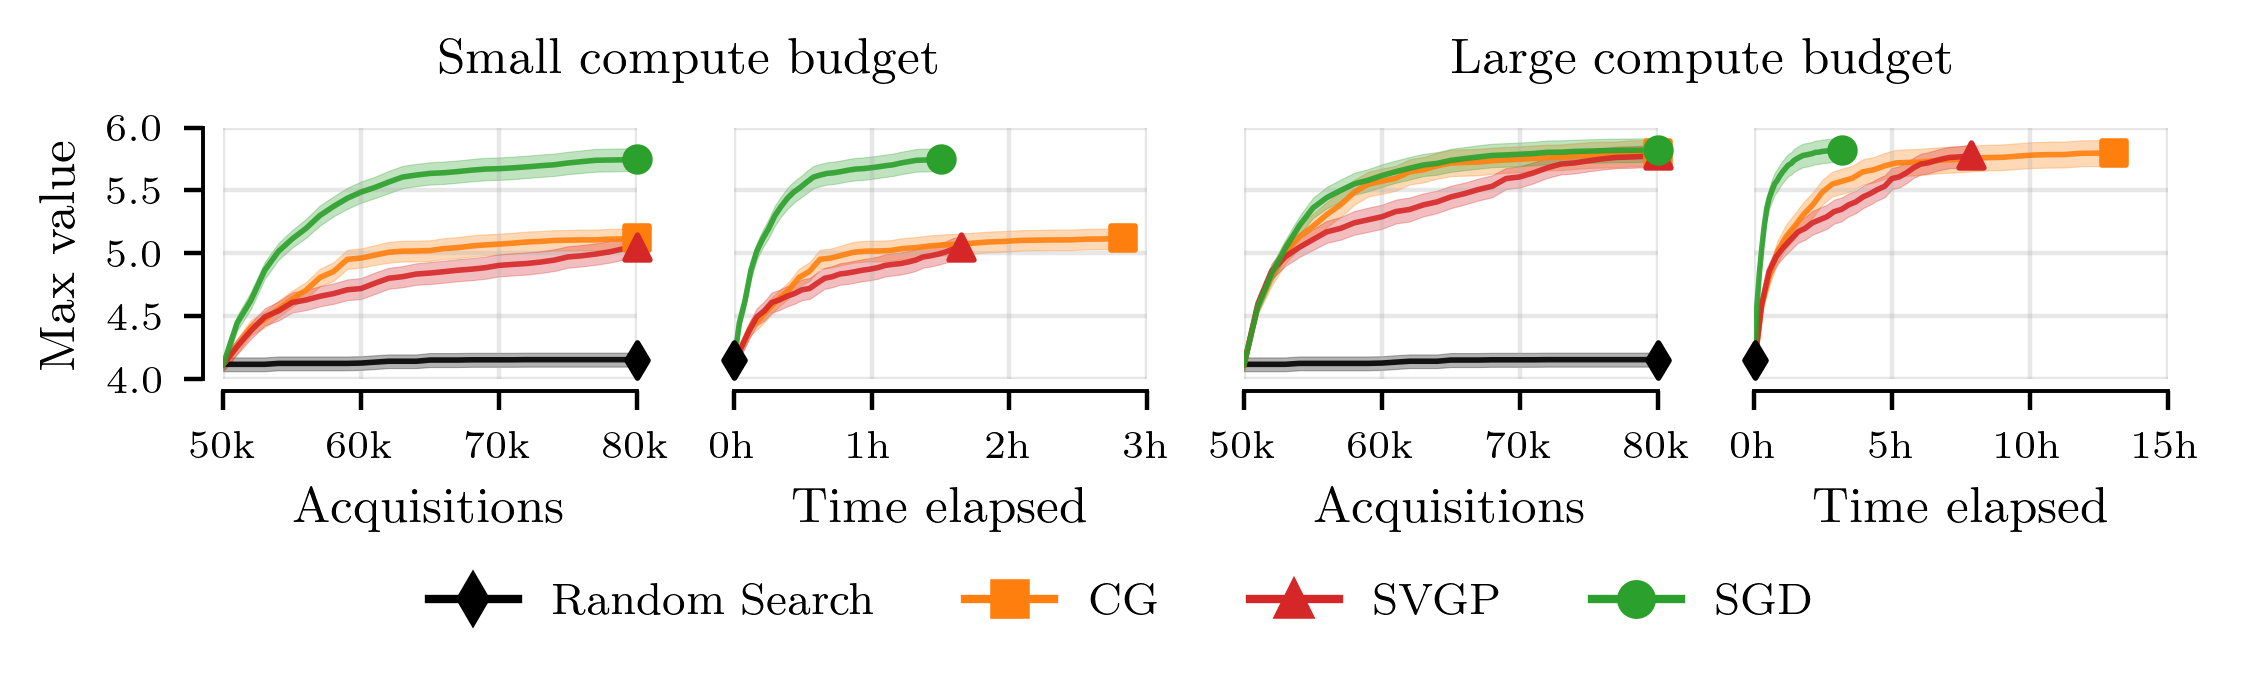

In [62]:
# aggregate over seeds AND length_scales
steps = range(n_thompson_steps + 1)

fig = plt.figure(dpi=400, figsize=[text_width, 0.14 * text_height])

steps_xlim = [0, 30]
steps_xticks = [0, 10, 20, 30]
steps_xticklabels = ["50k", "60k", "70k", "80k"]
steps_xlabel = "Acquisitions"

# small, steps
ax1 = fig.add_subplot(1, 4, 1)
ax1.set_xlim(*steps_xlim)
ax1.set_xticks(steps_xticks)
ax1.set_xticklabels(steps_xticklabels)
ax1.set_xlabel(steps_xlabel)
ax1.set_ylabel("Max value")

# large, steps
ax2 = fig.add_subplot(1, 4, 3)
ax2.set_xlim(*steps_xlim)
ax2.set_xticks(steps_xticks)
ax2.set_xticklabels(steps_xticklabels)
ax2.set_xlabel(steps_xlabel)

# small, time
ax3 = fig.add_subplot(1, 4, 2)
ax3.set_xlim([0, 3])
ax3.set_xticks([0, 1, 2, 3])
ax3.set_xticklabels(["0h", "1h", "2h", "3h"])
ax3.set_xlabel("Time elapsed")

# large, time
ax4 = fig.add_subplot(1, 4, 4)
ax4.set_xlim([0, 15])
ax4.set_xticks([0, 5, 10, 15])
ax4.set_xticklabels(["0h", "5h", "10h", "15h"])
ax4.set_xlabel("Time elapsed")

axes = [ax1, ax2, ax3, ax4]
for ax in axes:
    ax.grid(alpha=0.3)
    # ax.semilogy()
    ax.set_ylim(4.0, 6.0)
    ax.set_yticks([4.0, 4.5, 5.0, 5.5, 6.0])

    ax.spines[['top', 'right']].set_visible(False)
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))

    if ax != ax1:
        ax.spines['left'].set_visible(False)
        remove_yticks(ax)

def _plot(sweep, ax_steps, ax_time, steps, time, mean, err):
    c = get_color(sweep)
    ls = get_linestyle(sweep)
    m = get_marker(sweep)
    errorfill(ax_steps, steps, mean, err, color=c, linestyle=ls, alpha_fill=alpha_fill, alpha_line=alpha_line)
    errorfill(ax_time, time, mean, err, color=c, linestyle=ls, alpha_fill=alpha_fill, alpha_line=alpha_line)
    ax_steps.scatter(steps[-1], mean[-1], marker=m, c=c, s=markersize, zorder=3, alpha=alpha_marker, clip_on=False)
    ax_time.scatter(time[-1], mean[-1], marker=m, c=c, s=markersize, zorder=3, alpha=alpha_marker, clip_on=False)

for sweep in sweeps:
    mean = np.mean(results[sweep]['max_fn_value'], axis=(0, 1))
    err = np.std(results[sweep]['max_fn_value'], axis=(0, 1)) / np.sqrt(n_seeds  * n_length_scales)

    time = np.mean(results[sweep]['thompson_time'], axis=(0, 1)) / 60 / 60
    # time_std = np.std(results[sweep]['thompson_time'], axis=(0, 1))
    # print(time_std)

    if 'small' in sweep or sweep == 'random-search':
        _plot(sweep, ax1, ax3, steps, time, mean, err)
    if 'large' in sweep or sweep == 'random-search':
        _plot(sweep, ax2, ax4, steps, time, mean, err)

legend_handles = []
for method in ['random-search', 'cg', 'vi', 'sgd']:
    legend_handles.append(Line2D([], [], color=get_color(method), marker=get_marker(method), label=get_label(method)))
fig.legend(handles=legend_handles, ncols=4, loc='center', bbox_to_anchor=(0.5, -0.05), fontsize=8, frameon=False)

fig.text(0.195, 1.0, "Small compute budget")
fig.text(0.647, 1.0, "Large compute budget")

fig.tight_layout(pad=0.8)
fig.savefig("../../figures/thompson.png", bbox_inches='tight', pad_inches=0.01)
fig.savefig("../../figures/thompson.pdf", bbox_inches='tight', pad_inches=0.01)

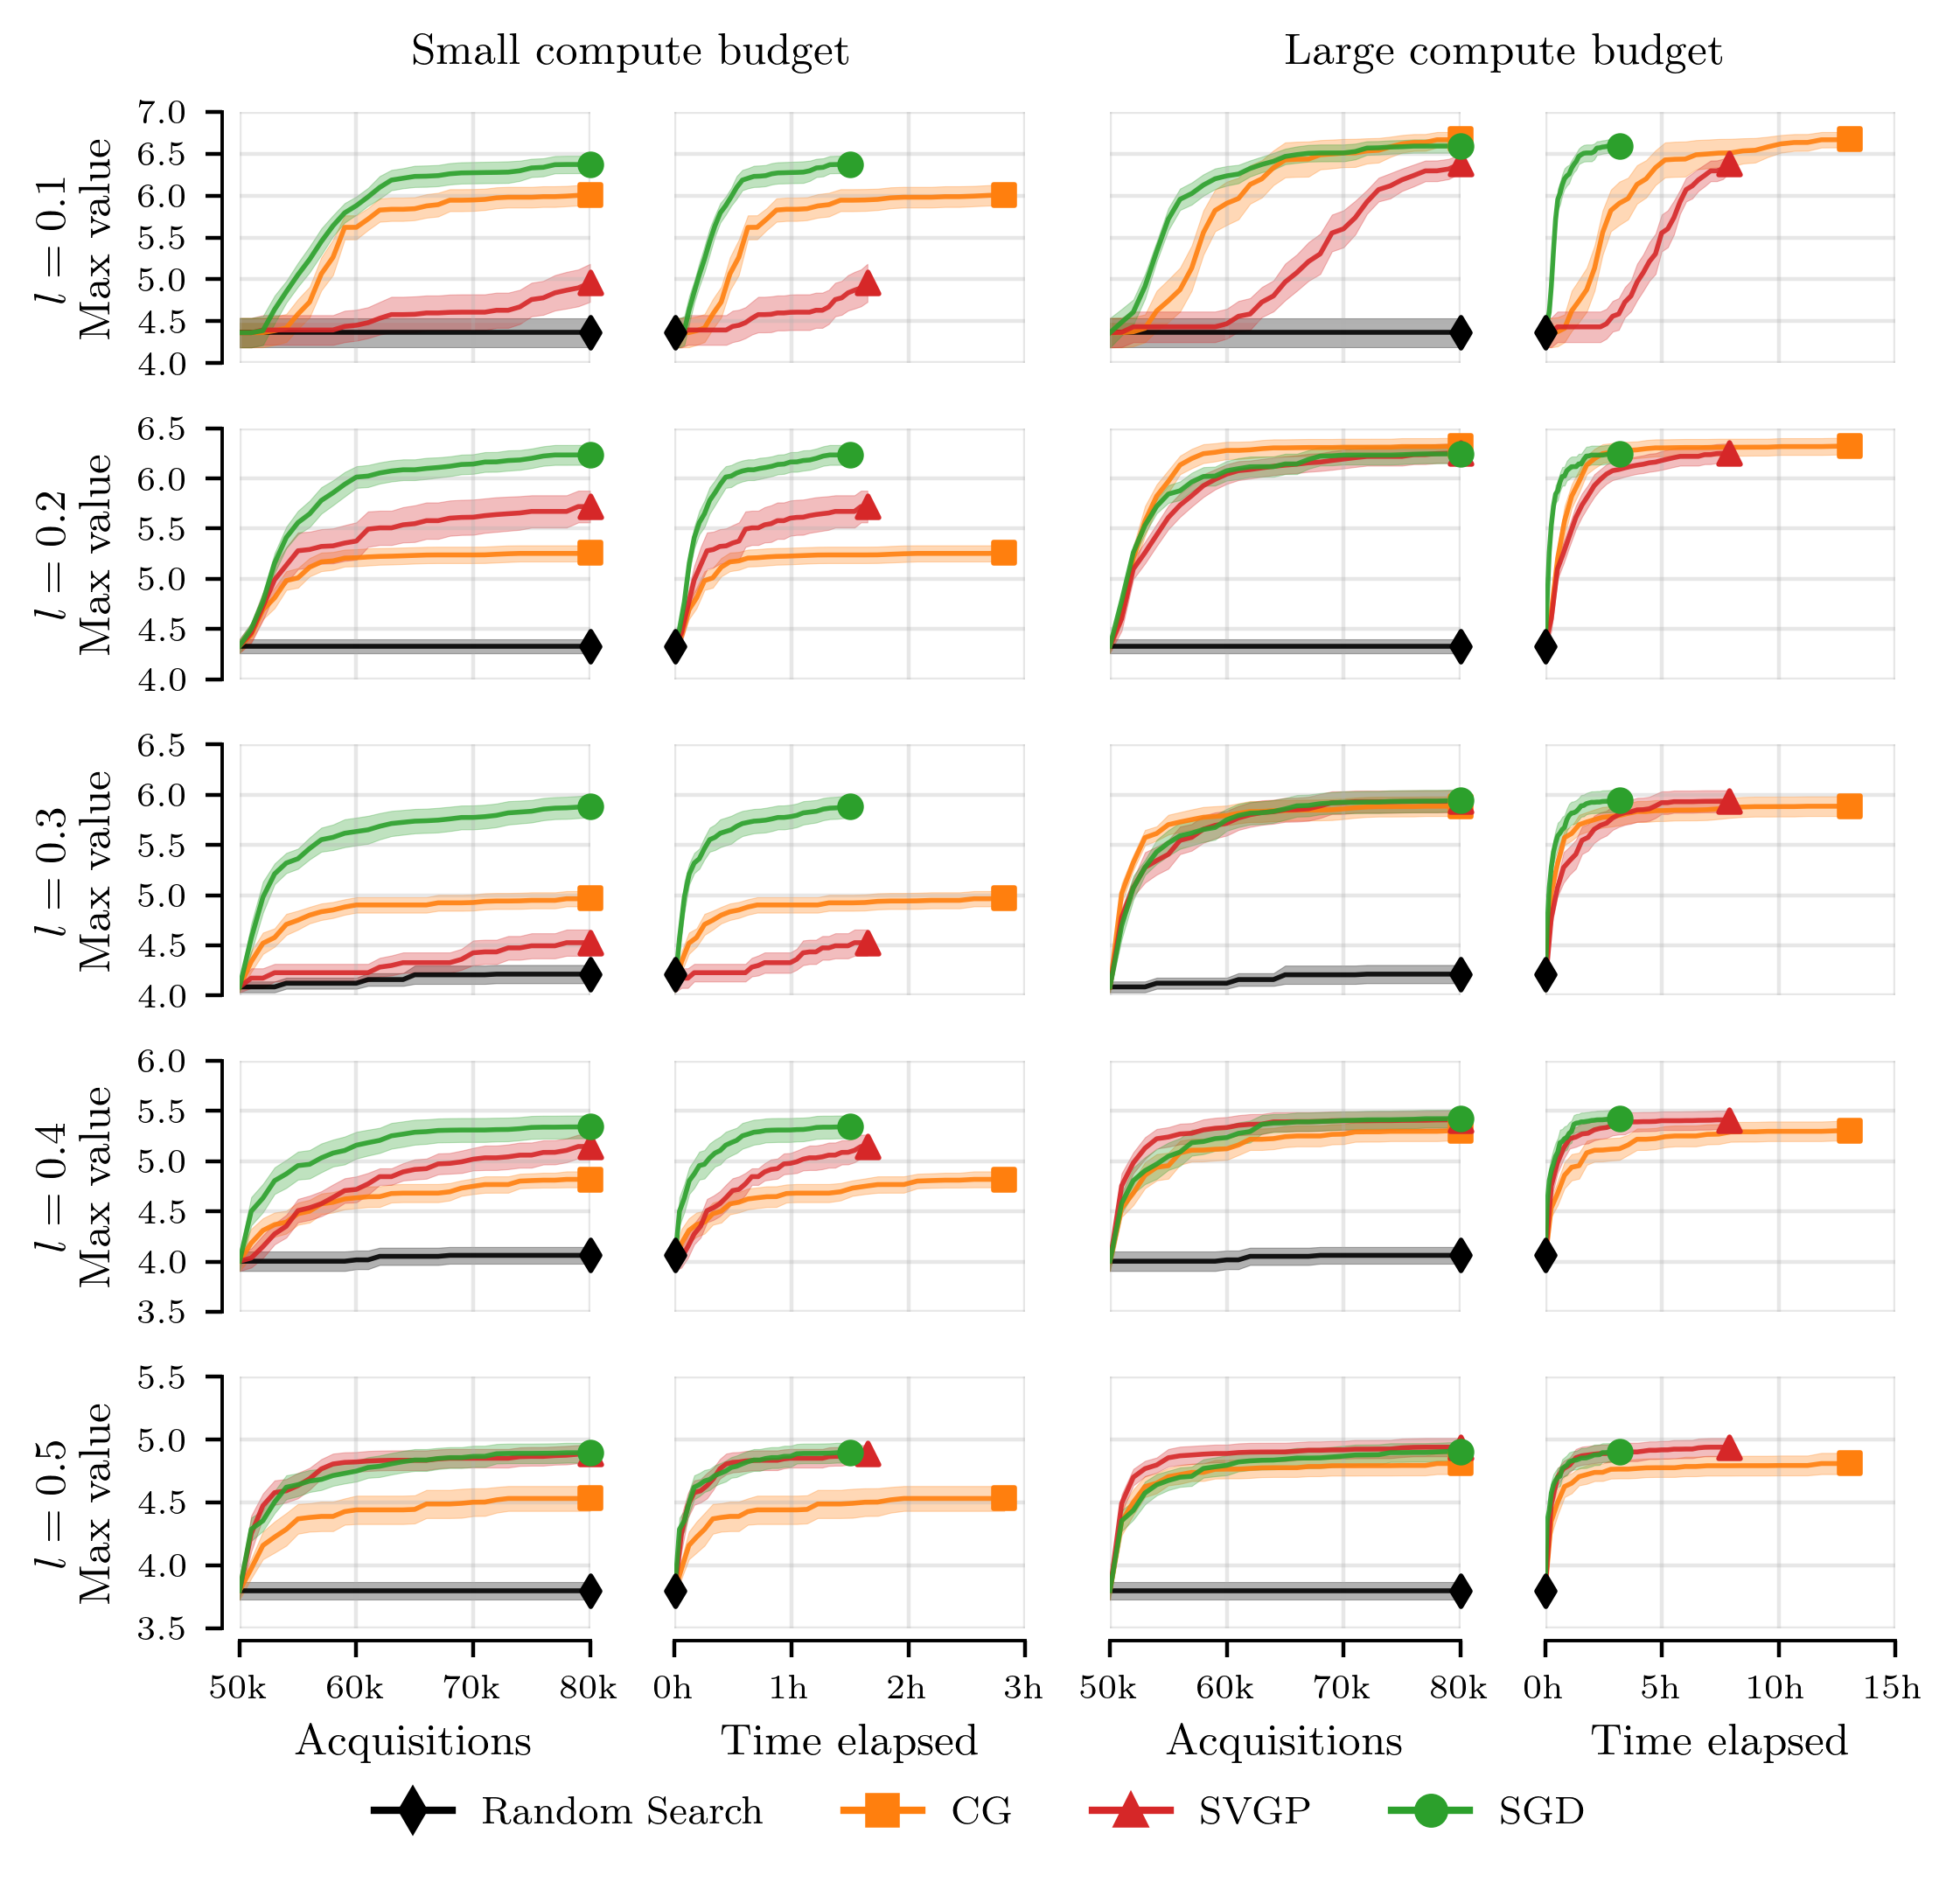

In [63]:
# aggregate over seeds but NOT length_scales
steps = range(n_thompson_steps + 1)

fig = plt.figure(dpi=400, figsize=[text_width, 0.55 * text_height])

length_scales = [0.1, 0.2, 0.3, 0.4, 0.5]
rows = len(length_scales)
cols = 4

for i, length_scale in enumerate(length_scales):
    # small, steps
    ax1 = fig.add_subplot(rows, 4, i * cols + 1)
    ax1.set_xlim(*steps_xlim)
    ax1.set_xticks(steps_xticks)
    ax1.set_xticklabels(steps_xticklabels)
    ax1.set_xlabel(steps_xlabel)
    ax1.set_ylabel(r"$l = {}$".format(length_scale)+"\nMax value")

    # large, steps
    ax2 = fig.add_subplot(rows, 4, i * cols + 3)
    ax2.set_xlim(*steps_xlim)
    ax2.set_xticks(steps_xticks)
    ax2.set_xticklabels(steps_xticklabels)
    ax2.set_xlabel(steps_xlabel)

    # small, time
    ax3 = fig.add_subplot(rows, 4, i * cols + 2)
    ax3.set_xlim([0, 3])
    ax3.set_xticks([0, 1, 2, 3])
    ax3.set_xticklabels(["0h", "1h", "2h", "3h"])
    ax3.set_xlabel("Time elapsed")

    # large, time
    ax4 = fig.add_subplot(rows, 4, i * cols + 4)
    ax4.set_xlim([0, 15])
    ax4.set_xticks([0, 5, 10, 15])
    ax4.set_xticklabels(["0h", "5h", "10h", "15h"])
    ax4.set_xlabel("Time elapsed")

    axes = [ax1, ax2, ax3, ax4]
    for ax in axes:
        ax.grid(alpha=0.3)
        # ax.set_ylim(3.5, 7.0)
        # ax.set_yticks([3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0])

        if length_scale == 0.1:
            ax.set_ylim(4.0, 7.0)
            ax.set_yticks([4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0])
        elif length_scale == 0.2:
            ax.set_ylim(4.0, 6.5)
            ax.set_yticks([4.0, 4.5, 5.0, 5.5, 6.0, 6.5])
        elif length_scale == 0.3:
            ax.set_ylim(4.0, 6.5)
            ax.set_yticks([4.0, 4.5, 5.0, 5.5, 6.0, 6.5])
        elif length_scale == 0.4:
            ax.set_ylim(3.5, 6.0)
            ax.set_yticks([3.5, 4.0, 4.5, 5.0, 5.5, 6.0])
        elif length_scale == 0.5:
            ax.set_ylim(3.5, 5.5)
            ax.set_yticks([3.5, 4.0, 4.5, 5.0, 5.5])

        ax.spines[['top', 'right']].set_visible(False)
        ax.spines['bottom'].set_position(('axes', -0.05))
        ax.spines['left'].set_position(('axes', -0.05))

        if ax != ax1:
            ax.spines['left'].set_visible(False)
            remove_yticks(ax)
        
        if i != rows - 1:
            ax.spines['bottom'].set_visible(False)
            remove_xticks(ax)
            ax.set_xlabel(None)

    for sweep in sweeps:
        mean = np.mean(results[sweep]['max_fn_value'][:, i], axis=0)
        err = np.std(results[sweep]['max_fn_value'][:, i], axis=0) / np.sqrt(n_seeds)

        time = np.mean(results[sweep]['thompson_time'], axis=(0, 1)) / 60 / 60

        if 'small' in sweep or sweep == 'random-search':
            _plot(sweep, ax1, ax3, steps, time, mean, err)
        if 'large' in sweep or sweep == 'random-search':
            _plot(sweep, ax2, ax4, steps, time, mean, err)

legend_handles = []
for method in ['random-search', 'cg', 'vi', 'sgd']:
    legend_handles.append(Line2D([], [], color=get_color(method), marker=get_marker(method), label=get_label(method)))
fig.legend(handles=legend_handles, ncols=4, loc='center', bbox_to_anchor=(0.5, -0.01), fontsize=8, frameon=False)

fig.text(0.21, 1.0, "Small compute budget")
fig.text(0.655, 1.0, "Large compute budget")

fig.tight_layout(pad=0.8)
fig.savefig("../../figures/thompson_length_scales.png", bbox_inches='tight', pad_inches=0.01)
fig.savefig("../../figures/thompson_length_scales.pdf", bbox_inches='tight', pad_inches=0.01)